### Import Section

In [91]:
# Fundamentals
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
import time

# Modeling Fundamentals
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.metrics import make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline

# Evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score

# Ignore Future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);
# Max column width
pd.set_option('display.max_colwidth', None)

# Import pickle to save model
import pickle

##### Replace with your filepath

In [92]:
df = pd.read_csv('/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/united_states_headlines_last_decade.csv')


##### View columns

In [93]:
df.columns

Index(['Unnamed: 0', 'abstract', 'headline', 'pub_date', 'year',
       'section_name', 'news_desk', 'keyword'],
      dtype='object')

##### View section names distribution, these will be the basis for a fair portion of analysis throughout the course of this project

In [94]:
df['section_name'].value_counts(normalize=True)

section_name
U.S.                    0.364239
Opinion                 0.234201
World                   0.131253
Business Day            0.080877
Sports                  0.027325
Health                  0.024385
Science                 0.011722
Podcasts                0.011173
Technology              0.009918
The Upshot              0.009801
New York                0.008821
Arts                    0.008115
Briefing                0.008037
Magazine                0.006547
Travel                  0.006508
Blogs                   0.006469
Multimedia/Photos       0.005920
Books                   0.005645
Food                    0.005606
Climate                 0.005449
Automobiles             0.003999
Your Money              0.003999
Real Estate             0.003371
Style                   0.003175
Sunday Review           0.001999
Well                    0.001490
Fashion & Style         0.001372
Education               0.001255
Times Insider           0.001176
Movies                  0.0010

##### Drop unnecessary columns

In [95]:
columns_to_drop = ['Unnamed: 0', 'keyword', 'news_desk', 'keyword','pub_date','year']

In [96]:
df = df.drop(columns=columns_to_drop)

In [97]:
df

,abstract,headline,section_name
0,"With the New Start treaty nearly wrapped up, President Obama should begin discussing other, more far-reaching deals with Russia.",The Next Treaties,Opinion
1,A response to a plea by Israel for the release of Jonathan Pollard.,Plea for Pollard’s Release,Opinion
2,Letters to the editor regarding tensions between New York medical schools and those in the Caribbean.,Where Do Doctors Learn Best?,Opinion
3,"Canada beat the United States in the semifinals of the world junior tournament, advancing to the final for the 10th consecutive year.",Canada Beats United States in World Junior Semifinal,Sports
4,"Kristine Lilly, who holds the world record with 352 international appearances for the U.S., announced her retirement on Wednesday.","Lilly, Iron Lady of U.S. Soccer, Retires at 39",Sports
...,...,...,...
25505,Unconscious bias in the medical profession may be raising risks for pregnant Black women.,How Bias Endangers Pregnant Black Women,Health
25506,"The Upshot staff shares a selection of their favorite charts, documents, queries and calculations from the past year.",10 Data Points and Documents That Made Us 🤔 in 2023,The Upshot
25507,The move comes as Israel presses on with its offensive in Gaza despite increasing pressure from the United States to lower the conflict’s intensity.,Biden Administration Again Bypasses Congress for Weapons Sale to Israel,World
25508,President Biden seems nervous about sealing a deal that would improve the health and quality of life of millions of Americans through a stricter rule on truck emissions.,"Electrify All the Big, Noisy, Belching Trucks",Opinion


##### Save newly edited dataframe - replace with your relative file path

In [98]:
# df.to_csv('/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/df_with_section_names.csv')

##### First step is correctly identifying whether an abstract/headline coupling is from the `Opinion` section or a `non-Opinion` section. This will be the basis of a binary classification model within this file. 

##### Binary classification: True label i.e. '1' denotes positive class, i.e. `Opinion` piece, False label i.e. '0' a `non-Opinion` piece. 



In [99]:
df['section_name'] = np.where(df['section_name'] == 'Opinion', 1, 0)

##### Verify this was accomplished successfully. 

In [100]:
df

,abstract,headline,section_name
0,"With the New Start treaty nearly wrapped up, President Obama should begin discussing other, more far-reaching deals with Russia.",The Next Treaties,1
1,A response to a plea by Israel for the release of Jonathan Pollard.,Plea for Pollard’s Release,1
2,Letters to the editor regarding tensions between New York medical schools and those in the Caribbean.,Where Do Doctors Learn Best?,1
3,"Canada beat the United States in the semifinals of the world junior tournament, advancing to the final for the 10th consecutive year.",Canada Beats United States in World Junior Semifinal,0
4,"Kristine Lilly, who holds the world record with 352 international appearances for the U.S., announced her retirement on Wednesday.","Lilly, Iron Lady of U.S. Soccer, Retires at 39",0
...,...,...,...
25505,Unconscious bias in the medical profession may be raising risks for pregnant Black women.,How Bias Endangers Pregnant Black Women,0
25506,"The Upshot staff shares a selection of their favorite charts, documents, queries and calculations from the past year.",10 Data Points and Documents That Made Us 🤔 in 2023,0
25507,The move comes as Israel presses on with its offensive in Gaza despite increasing pressure from the United States to lower the conflict’s intensity.,Biden Administration Again Bypasses Congress for Weapons Sale to Israel,0
25508,President Biden seems nervous about sealing a deal that would improve the health and quality of life of millions of Americans through a stricter rule on truck emissions.,"Electrify All the Big, Noisy, Belching Trucks",1


# Train Test Split and Cleaning

##### Train Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(df[['abstract', 'headline']],
                                                    df['section_name'],
                                                    train_size = 0.80,
                                                    random_state = 42)

##### Use of Regular Expressions to preprocess strings

In [102]:
def filtered_words(train_data):
    # Function to convert a raw post to a string of words
    # The input is a single string (a raw abstract or headline), and 
    # the output is a single string (a preprocessed abstact or headlines from an article)
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", train_data)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

total_abs_headlines = df.shape[0]
print(f'There are {total_abs_headlines} posts.')

# Initialize an empty list to hold the clean abstracts and headlines.
clean_train_abs = []
clean_test_abs = []
clean_train_lines = []
clean_test_lines = []

print("Cleaning and parsing the training set abstracts...")

j = 0
for train_abs in X_train['abstract']:
    # Convert abstract to words, then append to clean_train_abs.
    train_abs_str = str(train_abs)
    clean_train_abs.append(filtered_words(train_abs_str))   
    # If the index is divisible by 5000, print a message
    if (j + 1) % 5000 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
    
    j += 1

print("Cleaning and parsing the testing set abstracts...")
# Do the same for testing set.
for test_abs in X_test['abstract']:
    # Convert abstract to words, then append to clean_test_abs.
    test_abs_str = str(test_abs)
    clean_test_abs.append(filtered_words(test_abs_str))
    
    # If the index is divisible by 500, print a message
    if (j + 1) % 500 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
        
    j += 1

print("Cleaning and parsing the training set headlines...")

j = 0
for train_lines in X_train['headline']:
    # Convert headline to words, then append to clean_train_lines.
    train_lines_str = str(train_lines)
    clean_train_lines.append(filtered_words(train_lines_str))
    
    # If the index is divisible by 5000, print a message
    if (j + 1) % 5000 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
    
    j += 1

print("Cleaning and parsing the testing set headlines...")
# Do the same for testing set.
for test_lines in X_test['headline']:
    # Convert headline to words, then append to clean_test_lines.
    test_lines_str = str(test_lines)
    clean_test_lines.append(filtered_words(test_lines_str))
    
    # If the index is divisible by 500, print a message
    if (j + 1) % 500 == 0:
        print(f'Post {j + 1} of {total_abs_headlines}.')
        
    j += 1


There are 25510 posts.
Cleaning and parsing the training set abstracts...
Post 5000 of 25510.
Post 10000 of 25510.
Post 15000 of 25510.
Post 20000 of 25510.
Cleaning and parsing the testing set abstracts...
Post 20500 of 25510.
Post 21000 of 25510.
Post 21500 of 25510.
Post 22000 of 25510.
Post 22500 of 25510.
Post 23000 of 25510.
Post 23500 of 25510.
Post 24000 of 25510.
Post 24500 of 25510.
Post 25000 of 25510.
Post 25500 of 25510.
Cleaning and parsing the training set headlines...


Post 5000 of 25510.
Post 10000 of 25510.
Post 15000 of 25510.
Post 20000 of 25510.
Cleaning and parsing the testing set headlines...
Post 20500 of 25510.
Post 21000 of 25510.
Post 21500 of 25510.
Post 22000 of 25510.
Post 22500 of 25510.
Post 23000 of 25510.
Post 23500 of 25510.
Post 24000 of 25510.
Post 24500 of 25510.
Post 25000 of 25510.
Post 25500 of 25510.


##### Combine into one train total

In [103]:
clean_train_abs = pd.Series(clean_train_abs)
clean_train_lines = pd.Series(clean_train_lines)

# Combine the lists element-wise
clean_train_total = clean_train_abs + ' ' + clean_train_lines

# Display the result
clean_train_total

0                                                                                                                                 see latest charts maps coronavirus cases deaths hospitalizations garfield county montana garfield county montana covid case risk tracker
1                                                                                                                                   biggest increases come groups past far less likely babies highly educated women women never married u fertility rate yet women mothers
2        miguel cardona education secretary said reopening nation schools without addressing time lost learning pandemic would insufficient called schools use federal stimulus funds invest mental health counseling tutoring cardona urges schools invest extra tutoring
3                                                                                                                                                   mohamed morsi egypt first democratically elected pr

##### Ensure this worked

In [104]:
clean_train_lines[456]

'u partisanship highest decades pew study finds'

In [105]:
clean_train_abs[456]

'negativity fear anger among democrats republicans rise research shows'

In [106]:
clean_train_total[456]

'negativity fear anger among democrats republicans rise research shows u partisanship highest decades pew study finds'

##### Combine into one test total

In [107]:
clean_test_abs = pd.Series(clean_test_abs)
clean_test_lines = pd.Series(clean_test_lines)

# Combine the lists element-wise
clean_test_total = clean_test_abs + ' ' + clean_test_lines

# Display the result
clean_test_total

0                                                                                                          see full results maps california election california election results th congressional district
1                                                                                                                           campuses challenging definition rape many states redefining law regulating sex
2                        move radical departure country historically dependable american ally southeast asia could undermine president obama foreign policy behind duterte bluster philippine shift away u
3                                   appeal help united states rushing dozens missiles surveillance drones help iraqi forces combat violence qaeda backed insurgency u sends arms aid iraq fight extremists
4                                                               see latest charts maps coronavirus cases deaths hospitalizations atchison county missouri atchison county missouri covid cas

##### Ensure this worked

In [108]:
clean_test_abs[456]

'two recent supreme court decisions reduce abusive frivolous patent litigation increased sharply recent years'

In [109]:
clean_test_lines[456]

'clarifying tightening patent law'

In [110]:
clean_test_total[456]

'two recent supreme court decisions reduce abusive frivolous patent litigation increased sharply recent years clarifying tightening patent law'

#### The element-wise concatentation worked proceed to modeling section

In [111]:
type(clean_train_total)

pandas.core.series.Series

In [112]:
clean_train_total = clean_train_total.tolist()

In [113]:
clean_test_total = clean_test_total.tolist()

In [114]:
type(clean_train_total)

list

In [115]:
type(clean_test_total)

list

##### For usage with part 3 - see documentation for details

In [116]:
summed_lists = clean_train_total + clean_test_total

In [117]:
labels = df['section_name'].tolist()

In [118]:
corpus_df = pd.DataFrame({'Document': summed_lists, 
                          'Category': labels})

In [119]:

corpus_df.head(26)

,Document,Category
0,see latest charts maps coronavirus cases deaths hospitalizations garfield county montana garfield county montana covid case risk tracker,1
1,biggest increases come groups past far less likely babies highly educated women women never married u fertility rate yet women mothers,1
2,miguel cardona education secretary said reopening nation schools without addressing time lost learning pandemic would insufficient called schools use federal stimulus funds invest mental health counseling tutoring cardona urges schools invest extra tutoring,1
3,mohamed morsi egypt first democratically elected president said washington revitalize alliance egypt relations egypt u,0
4,see full results maps district columbia elections district columbia election results,0
5,see full results maps arizona special election arizona u senate special election results,0
6,nan oklahoma presidential republican primary election results,0
7,signatories letter sent president trump many cabinet members include former secretaries state madeleine albright john kerry trump revised travel ban denounced foreign policy experts,0
8,study facebook use suggests may become less self obsessed age get less narcissistic get older,0
9,president trump stance legal undocumented immigrants could devastating results american family makes country great danger,0


##### Uncomment this line and insert relative file path for Word2Vec and related context-based neural network algorithms (See section 3)

In [120]:

# corpus_df.to_csv('/Users/ben/Desktop/DSI_GA_Materials/capstone/Capstone_Project_backup/Data/dfnew_with_section_names.csv')

# Preliminary Modeling Section

# Baseline accuracy
Calculate baseline accuracy in order to tell if model is better than null model (predicting the plurality class).

In [121]:
df['section_name'].value_counts(normalize=True)

section_name
0    0.765817
1    0.234183
Name: proportion, dtype: float64

In [122]:
# Baseline prediction dem 1 rep 0
y_train.value_counts(normalize=True)

section_name
0    0.765729
1    0.234271
Name: proportion, dtype: float64

In [123]:
print(f"Difference metric | {round(np.abs(np.mean(df['section_name'])-np.mean(y_train)), 5)}")

Difference metric | 9e-05


# Classification Modeling Section

## Logistic regression - Not Optimal We Transition To Other Models Following

In [124]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    # ('ss', StandardScaler(with_mean=False)),
    ('lr',LogisticRegression())
])

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    # ('ss', StandardScaler(with_mean=False)),
    ('lr',LogisticRegression()) 
])

pipe_params1 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
               'cvec__ngram_range': [(1,1), (1,2)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
                'lr__C': [0.1, 1, 10, 100],
                'lr__penalty': ['l1', 'l2'],
                'lr__max_iter': [1000],
              }

pipe_params2 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
               'tvec__ngram_range' : [(1, 1), (1, 2)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'lr__C': [0.1, 1, 10, 100],
                'lr__penalty': ['l1', 'l2'],
                'lr__max_iter': [1000], # Do not go lower than 1000 fail to converge
              }

# Instantiate GridSearchCV.

gs1 = GridSearchCV(pipe1, # what object are we optimizing?
                  param_grid=pipe_params1, # what parameters values are we searching?
                  cv=5,
                  n_jobs=-1) # 5-fold cross-validation.

gs2 = GridSearchCV(pipe2, # what object are we optimizing?
                  param_grid=pipe_params2, # what parameters values are we searching?
                  cv=5, 
                  n_jobs=-1) # 5-fold cross-validation.

gs1.fit(clean_train_total, y_train)

gs2.fit(clean_train_total, y_train)

/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1200 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ben/miniforge3/lib/python3.10/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10, 100], 'lr__max_iter': [1000],
                         'lr__penalty': ['l1', 'l2'],
                         'tvec__max_df': [0.6, 0.65, 0.7],
                         'tvec__max_features': [5000, 6000, 7000, 8000, 9000],
                         'tvec__min_df': [5e-05, 0.0001],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [125]:
# max iter was 1000 before non convergence warnings all other parameters were defaults
'''
gs1:
{'cvec__max_df': 0.6,
 'cvec__max_features': 9000,
 'cvec__min_df': 5e-05,
 'cvec__ngram_range': (1, 1),
 'lr__C': 1,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2'}
'''
print(gs1.best_params_)

{'cvec__max_df': 0.6, 'cvec__max_features': 9000, 'cvec__min_df': 5e-05, 'cvec__ngram_range': (1, 1), 'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2'}


In [126]:
cvec_lr_optimized = CountVectorizer(max_df = 0.6,
 max_features = 9000,
 min_df = 5e-05,
 ngram_range= (1, 1))

In [127]:
tvec_lr_optimized = TfidfVectorizer(max_df= 0.6,max_features= 7000,min_df= 5e-05,ngram_range= (1, 1))

In [128]:
lr_cvec_opt = LogisticRegression(C = 1, max_iter = 1000, penalty= 'l2')

In [129]:
lr_tvec_opt = LogisticRegression(C = 10, max_iter = 1000, penalty = 'l2')

In [130]:
cvec_lr_optimized_clean_train_total = cvec_lr_optimized.fit_transform(clean_train_total)

In [131]:
cvec_lr_optimized_clean_test_total = cvec_lr_optimized.transform(clean_test_total)

In [132]:
tvec_lr_optimized_clean_train_total = tvec_lr_optimized.fit_transform(clean_train_total)

In [133]:
tvec_lr_optimized_clean_test_total = tvec_lr_optimized.transform(clean_test_total)

In [134]:
lr_cvec_opt.fit(cvec_lr_optimized_clean_train_total, y_train)

LogisticRegression(C=1, max_iter=1000)

In [135]:
lr_tvec_opt.fit(tvec_lr_optimized_clean_train_total, y_train)

LogisticRegression(C=10, max_iter=1000)

In [136]:
print(f"Train Accuracy Score CVec LR| {round(lr_cvec_opt.score(cvec_lr_optimized_clean_train_total, y_train),3)}")
print(f"Test Accuracy Score CVec LR| {round(lr_cvec_opt.score(cvec_lr_optimized_clean_test_total, y_test),3)}")

Train Accuracy Score CVec LR| 0.974
Test Accuracy Score CVec LR| 0.889


In [137]:
print(f"Train Accuracy Score TVec LR| {round(lr_tvec_opt.score(tvec_lr_optimized_clean_train_total, y_train),3)}")
print(f"Test Accuracy Score TVec LR| {round(lr_tvec_opt.score(tvec_lr_optimized_clean_test_total, y_test),3)}")

Train Accuracy Score TVec LR| 0.962
Test Accuracy Score TVec LR| 0.875


In [138]:
gs2.best_params_
'''
gs2: 
{'lr__C': 10,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.6,
 'tvec__max_features': 7000,
 'tvec__min_df': 5e-05,
 'tvec__ngram_range': (1, 1)}
'''

"\ngs2: \n{'lr__C': 10,\n 'lr__max_iter': 1000,\n 'lr__penalty': 'l2',\n 'tvec__max_df': 0.6,\n 'tvec__max_features': 7000,\n 'tvec__min_df': 5e-05,\n 'tvec__ngram_range': (1, 1)}\n"

In [139]:
print(f"Train Accuracy Score CVec LR| {round(gs1.score(clean_train_total, y_train),3)}")
print(f"Test Accuracy Score CVec LR| {round(gs1.score(clean_test_total, y_test),3)}")

Train Accuracy Score CVec LR| 0.974
Test Accuracy Score CVec LR| 0.889


In [140]:
print(f"Train Accuracy Score TVec LR| {round(gs2.score(clean_train_total, y_train),3)}")
print(f"Test Accuracy Score TVec LR| {round(gs2.score(clean_test_total, y_test),3)}")

Train Accuracy Score TVec LR| 0.962
Test Accuracy Score TVec LR| 0.875


TN: 3605
FP: 304
FN: 262
TP: 931


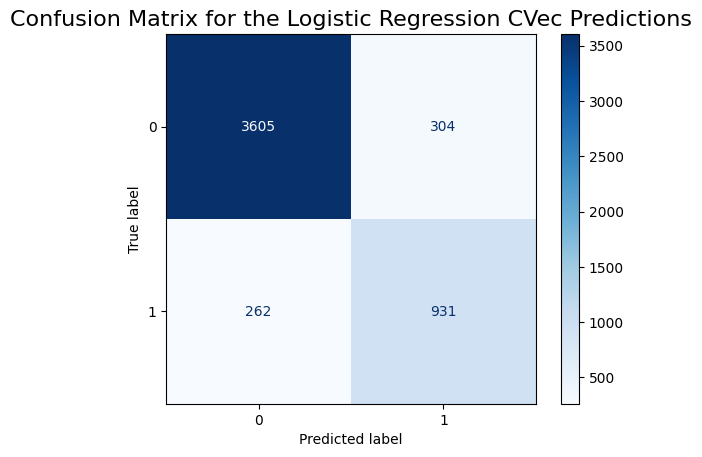

In [141]:
# Get predictions from optimal LR model
preds = gs1.predict(clean_test_total)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs1, clean_test_total, y_test, cmap='Blues');
plt.title('Confusion Matrix for the Logistic Regression CVec Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [142]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp/(tp+fn),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn/(tn+fp),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp+tn)/(tp+fp+tn+fn),3)}")
# Calculate Precision
print(f"Precision | {round(tp/(tp+fp),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp+fn)/(tp+fp+tn+fn),3)}")

Sensitivity | 0.78
Specificity | 0.922
Accuracy | 0.889
Precision | 0.754
Miscalculation Rate | 0.111


At the moment we are optimizing specificity, i.e. minimizing false positives (incorrectly telling the viewer that the abstract/headline pair belongs to an `Opinion` section) and this comes at the expense of increasing false negatives. 

Precision is improving but still not quite what it needs to be and thus we must continue along with other models in order to fine-tune to find the best classification model before we proceed to sentiment analysis of those articles within the `Opinion` section. 

TN: 3643
FP: 266
FN: 370
TP: 823


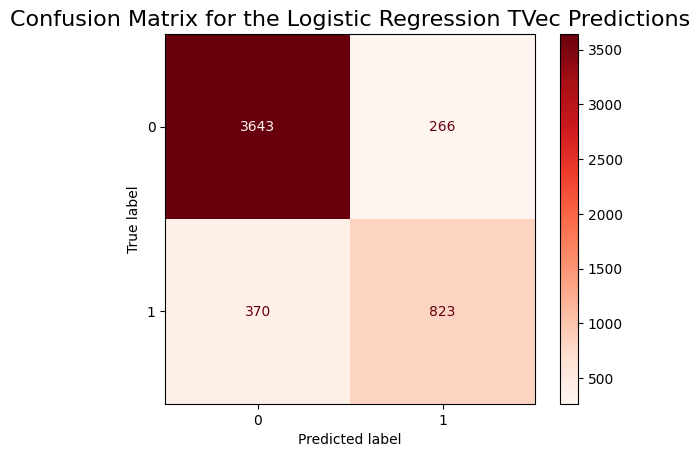

In [143]:
# Get predictions from optimal LR model
preds = gs2.predict(clean_test_total)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs2, clean_test_total, y_test, cmap='Reds');
plt.title('Confusion Matrix for the Logistic Regression TVec Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [144]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp/(tp+fn),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn/(tn+fp),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp+tn)/(tp+fp+tn+fn),3)}")
# Calculate Precision
print(f"Precision | {round(tp/(tp+fp),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp+fn)/(tp+fp+tn+fn),3)}")

Sensitivity | 0.69
Specificity | 0.932
Accuracy | 0.875
Precision | 0.756
Miscalculation Rate | 0.125


At the moment we are optimizing specificity, i.e. minimizing false positives (incorrectly telling the viewer that the abstract/headline pair belongs to an `Opinion` section) and this comes at the expense of increasing false negatives. 

Precision is improving but still not quite what it needs to be and thus we must continue along with other models in order to fine-tune to find the best classification model before we proceed to sentiment analysis of those articles within the `Opinion` section. 

##### Combine preds with original dataframe and check how our predictions performed

In [145]:
# Combine predictions with the original DataFrame
df_test_outcomes = pd.DataFrame({'X_test': clean_test_total, 'y_test': y_test, 'Predictions_LR_CVec': preds})


# Calculate confusion matrix
conf_matrix = pd.crosstab(df_test_outcomes['y_test'], df_test_outcomes['Predictions_LR_CVec'], rownames=['Actual'], colnames=['Predicted'])

# Extract values from the confusion matrix
true_negatives = conf_matrix[0][0]
false_positives = conf_matrix[0][1]
false_negatives = conf_matrix[1][0]
true_positives = conf_matrix[1][1]

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create lists for false positives and false negatives
false_positives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 0) & (df_test_outcomes['Predictions_LR_CVec'] == 1)]['X_test'].tolist()
false_negatives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 1) & (df_test_outcomes['Predictions_LR_CVec'] == 0)]['X_test'].tolist()


Confusion Matrix:
Predicted     0    1
Actual              
0          3643  266
1           370  823


In [146]:
# Function to get the most common words from a list
def get_most_common_words(text_list, top_n=10):
    all_text = ' '.join(text_list)
    words = all_text.split()
    counter = Counter(words)
    most_common_words = counter.most_common(top_n)
    return [word for word, _ in most_common_words]

# Get most common words from false positives and false negatives lists
top_words_false_positives = get_most_common_words(false_positives_list)
top_words_false_negatives = get_most_common_words(false_negatives_list)

# Combine the lists of most common words
common_stopwords = list(top_words_false_positives + top_words_false_negatives)

# Display the most common words
print("Most common words in False Positives:")
print(top_words_false_positives)

print("\nMost common words in False Negatives:")
print(top_words_false_negatives)

print("\nCombined stopwords for CountVectorizer:")
print(common_stopwords)

Most common words in False Positives:
['trump', 'u', 'america', 'american', 'new', 'people', 'states', 'president', 'many', 'women']

Most common words in False Negatives:
['states', 'america', 'american', 'trump', 'united', 'president', 'new', 'americans', 'u', 'one']

Combined stopwords for CountVectorizer:
['trump', 'u', 'america', 'american', 'new', 'people', 'states', 'president', 'many', 'women', 'states', 'america', 'american', 'trump', 'united', 'president', 'new', 'americans', 'u', 'one']


In [147]:
# Combine predictions with the original DataFrame
df_test_outcomes = pd.DataFrame({'X_test': clean_test_total, 'y_test': y_test, 'Predictions_LR_TVec': preds})


# Calculate confusion matrix
conf_matrix = pd.crosstab(df_test_outcomes['y_test'], df_test_outcomes['Predictions_LR_TVec'], rownames=['Actual'], colnames=['Predicted'])

# Extract values from the confusion matrix
true_negatives = conf_matrix[0][0]
false_positives = conf_matrix[0][1]
false_negatives = conf_matrix[1][0]
true_positives = conf_matrix[1][1]

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create lists for false positives and false negatives
false_positives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 0) & (df_test_outcomes['Predictions_LR_TVec'] == 1)]['X_test'].tolist()
false_negatives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 1) & (df_test_outcomes['Predictions_LR_TVec'] == 0)]['X_test'].tolist()


Confusion Matrix:
Predicted     0    1
Actual              
0          3643  266
1           370  823


In [148]:
# Get most common words from false positives and false negatives lists
top_words_false_positives = get_most_common_words(false_positives_list)
top_words_false_negatives = get_most_common_words(false_negatives_list)

# Combine the lists of most common words
common_stopwords = list(top_words_false_positives + top_words_false_negatives)

# Display the most common words
print("Most common words in False Positives:")
print(top_words_false_positives)

print("\nMost common words in False Negatives:")
print(top_words_false_negatives)

print("\nCombined stopwords for TfidfVectorizer:")
print(common_stopwords)

Most common words in False Positives:
['trump', 'u', 'america', 'american', 'new', 'people', 'states', 'president', 'many', 'women']

Most common words in False Negatives:
['states', 'america', 'american', 'trump', 'united', 'president', 'new', 'americans', 'u', 'one']

Combined stopwords for TfidfVectorizer:
['trump', 'u', 'america', 'american', 'new', 'people', 'states', 'president', 'many', 'women', 'states', 'america', 'american', 'trump', 'united', 'president', 'new', 'americans', 'u', 'one']


### Implementing the Custom Scorer and the combined stopwords (CVEC) - Commented Out and Results Were Marginal Improvement Over Model Without False Positive/Negative Stopwords

In [149]:
# custom_scorer = make_scorer(f1_score)

# # Common stopwords from the previous example
# # common_stopwords = set(common_stopwords)  # Replace with your actual common stopwords

# # Pipeline with CountVectorizer
# pipe1_a = Pipeline([
#     ('cvec', CountVectorizer(stop_words=common_stopwords)),
#     ('lr', LogisticRegression())
# ])

# # Pipeline with TfidfVectorizer
# pipe2_a = Pipeline([
#     ('tvec', TfidfVectorizer(stop_words=common_stopwords)),
#     ('lr', LogisticRegression())
# ])

# # Parameter grids with common stopwords
# pipe_params1_a = {
#     'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'cvec__ngram_range': [(1, 1), (1, 2)],
#     'cvec__min_df': [0.00005, 0.0001],
#     'cvec__max_df': [0.6, 0.65, 0.7],
#     'lr__C': [0.1, 1, 10, 100],
#     'lr__penalty': ['l1', 'l2'],
#     'lr__max_iter': [1000],
# }

# pipe_params2_a = {
#     'tvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'tvec__ngram_range': [(1, 1), (1, 2)],
#     'tvec__min_df': [0.00005, 0.0001],
#     'tvec__max_df': [0.6, 0.65, 0.7],
#     'lr__C': [0.1, 1, 10, 100],
#     'lr__penalty': ['l1', 'l2'],
#     'lr__max_iter': [1000],  # Do not go lower than 1000 fail to converge
# }

# # Instantiate GridSearchCV.
# gs1_a = GridSearchCV(pipe1_a,
#                    param_grid=pipe_params1_a,
#                    cv=5,
#                    n_jobs=-1,
#                    scoring=custom_scorer)

# gs2_a = GridSearchCV(pipe2_a,
#                    param_grid=pipe_params2_a,
#                    cv=5,
#                    n_jobs=-1,
#                    scoring=custom_scorer)

# # Measure the time taken for the parameter search
# start_time = time.time()
# gs1_a.fit(clean_train_total, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with CountVectorizer: {end_time - start_time:.2f} seconds")

# # start_time = time.time()
# # gs2_a.fit(clean_train_total, y_train)
# # end_time = time.time()
# # print(f"Time taken for GridSearchCV with TfidfVectorizer: {end_time - start_time:.2f} seconds")

In [150]:
# gs1_a.best_params_

In [151]:
# gs2_a.best_params_

In [152]:
# print(f"Train Accuracy Score CVec LR Stopwords| {round(gs1_a.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score CVec LR Stopwords| {round(gs1_a.score(clean_test_total, y_test),3)}")

In [153]:
# print(f"Train Accuracy Score TVec LR Stopwords| {round(gs2_a.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score TVec LR Stopwords| {round(gs2_a.score(clean_test_total, y_test),3)}")

In [154]:
# # Get predictions from optimal LR model
# preds_stp = gs1_a.predict(clean_test_total)
# # Save confusion matrix values
# tn1, fp1, fn1, tp1 = confusion_matrix(y_test, preds_stp).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs1_a, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Logistic Regression Stopwords CVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds_stp))

In [155]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp1/(tp1+fn1),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn1/(tn1+fp1),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp1+tn1)/(tp1+fp1+tn1+fn1),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp1/(tp1+fp1),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp1+fn1)/(tp1+fp1+tn1+fn1),3)}")

In [156]:
# # Get predictions from optimal LR model
# preds_stp2 = gs2_a.predict(clean_test_total)
# # Save confusion matrix values
# tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_stp2).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs2_a, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Logistic Regression Stopwords CVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds_stp2))

In [157]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp2/(tp2+fn2),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn2/(tn2+fp2),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp2+tn2)/(tp2+fp2+tn2+fn2),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp2/(tp2+fp2),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp2+fn2)/(tp2+fp2+tn2+fn2),3)}")

## Simple Bagging Regressor only tuned for cvec and tvec - Computationally Expensive and Commented Out

In [158]:
# pipe11 = Pipeline([
#     ('cvec', CountVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('bg',BaggingClassifier())
# ])

# pipe12 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('bg',BaggingClassifier())
# ])

# pipe_params11 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#                'cvec__ngram_range': [(1,1), (1,2)],
#                 'cvec__min_df': [0.00005, 0.0001],
#                 'cvec__max_df': [0.6,0.65,0.7],
#               }

# pipe_params12 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
#                'tvec__ngram_range' : [(1, 1), (1, 2)],
#                 'tvec__min_df': [0.00005, 0.0001],
#                 'tvec__max_df': [0.6,0.65,0.7],
#               }

# # Instantiate GridSearchCV.

# gs11 = GridSearchCV(pipe11, # what object are we optimizing?
#                   param_grid=pipe_params11, # what parameters values are we searching?
#                   cv=5,
#                   n_jobs=-1) # 5-fold cross-validation.

# gs12 = GridSearchCV(pipe12, # what object are we optimizing?
#                   param_grid=pipe_params12, # what parameters values are we searching?
#                   cv=5, 
#                   n_jobs=-1) # 5-fold cross-validation.

# gs11.fit(clean_train_total, y_train)

# gs12.fit(clean_train_total, y_train)

In [159]:
# gs11.best_params_

In [160]:
# gs12.best_params_

In [161]:
# print(f"Train Accuracy Score CVec Bagging Classifier| {round(gs11.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score CVec Bagging Classifier| {round(gs11.score(clean_test_total, y_test),3)}")

In [162]:
# print(f"Train Accuracy Score TVec Bagging Classifier| {round(gs12.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score TVec Bagging Classifier| {round(gs12.score(clean_test_total, y_test),3)}")

In [163]:
# # Get predictions from optimal BG model
# preds = gs11.predict(clean_test_total)
# # Save confusion matrix values
# tn11, fp11, fn11, tp11 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs11, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Bagging Classifier CVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [165]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp11/(tp11+fn11),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn11/(tn11+fp11),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp11+tn11)/(tp11+fp11+tn11+fn11),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp11/(tp11+fp11),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp11+fn11)/(tp11+fp11+tn11+fn11),3)}")

In [166]:
# # Get predictions from optimal BG model
# preds = gs12.predict(clean_test_total)
# # Save confusion matrix values
# tn12, fp12, fn12, tp12 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs12, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Bagging Classifier TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [167]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp12/(tp12+fn12),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn12/(tn12+fp12),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp12+tn12)/(tp12+fp12+tn12+fn12),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp12/(tp12+fp12),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp12+fn12)/(tp12+fp12+tn12+fn12),3)}")

In [168]:
# # Combine predictions with the original DataFrame
# df_test_outcomes = pd.DataFrame({'X_test': clean_test_total, 'y_test': y_test, 'Predictions_Bagging_CVec': preds})


# # Calculate confusion matrix
# conf_matrix = pd.crosstab(df_test_outcomes['y_test'], df_test_outcomes['Predictions_Bagging_CVec'], rownames=['Actual'], colnames=['Predicted'])

# # Extract values from the confusion matrix
# true_negatives = conf_matrix[0][0]
# false_positives = conf_matrix[0][1]
# false_negatives = conf_matrix[1][0]
# true_positives = conf_matrix[1][1]

# # Display the confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# # Create lists for false positives and false negatives
# false_positives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 0) & (df_test_outcomes['Predictions_Bagging_CVec'] == 1)]['X_test'].tolist()
# false_negatives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 1) & (df_test_outcomes['Predictions_Bagging_CVec'] == 0)]['X_test'].tolist()


In [169]:
# # Function to get the most common words from a list
# def get_most_common_words(text_list, top_n=10):
#     all_text = ' '.join(text_list)
#     words = all_text.split()
#     counter = Counter(words)
#     most_common_words = counter.most_common(top_n)
#     return [word for word, _ in most_common_words]

# # Get most common words from false positives and false negatives lists
# top_words_false_positives = get_most_common_words(false_positives_list)
# top_words_false_negatives = get_most_common_words(false_negatives_list)

# # Combine the lists of most common words
# common_stopwords = list(top_words_false_positives + top_words_false_negatives)

# # Display the most common words
# print("Most common words in False Positives:")
# print(top_words_false_positives)

# print("\nMost common words in False Negatives:")
# print(top_words_false_negatives)

# print("\nCombined stopwords for CountVectorizer:")
# print(common_stopwords)

##### Bagging Classifier GridSearch - Computationally Expensive

In [170]:
# # Pipeline with CountVectorizer and BaggingClassifier
# bagging_pipe1_a = Pipeline([
#     ('cvec', CountVectorizer(stop_words=common_stopwords)),
#     ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
# ])

# # Pipeline with TfidfVectorizer and BaggingClassifier
# bagging_pipe2_a = Pipeline([
#     ('tvec', TfidfVectorizer(stop_words=common_stopwords)),
#     ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
# ])

# # Parameter grids for BaggingClassifier
# bagging_params1_a = {
#     'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'cvec__ngram_range': [(1, 1), (1, 2)],
#     'cvec__min_df': [0.00005, 0.0001],
#     'cvec__max_df': [0.6, 0.65, 0.7],
#     'bagging__n_estimators': [10, 50, 100],
#     'bagging__max_samples': [0.5, 0.7, 1.0],
#     'bagging__max_features': [0.5, 0.7, 1.0],
# }

# bagging_params2_a = {
#     'tvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'tvec__ngram_range': [(1, 1), (1, 2)],
#     'tvec__min_df': [0.00005, 0.0001],
#     'tvec__max_df': [0.6, 0.65, 0.7],
#     'bagging__n_estimators': [10, 50, 100],
#     'bagging__max_samples': [0.5, 0.7, 1.0],
#     'bagging__max_features': [0.5, 0.7, 1.0],
# }

# # Instantiate GridSearchCV for BaggingClassifier
# gs_bagging1_a = GridSearchCV(bagging_pipe1_a,
#                              param_grid=bagging_params1_a,
#                              cv=5,
#                              n_jobs=-1,
#                              scoring=custom_scorer)

# gs_bagging2_a = GridSearchCV(bagging_pipe2_a,
#                              param_grid=bagging_params2_a,
#                              cv=5,
#                              n_jobs=-1,
#                              scoring=custom_scorer)

# # Measure the time taken for the parameter search
# start_time = time.time()
# gs_bagging1_a.fit(clean_train_total, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with BaggingClassifier and CountVectorizer: {end_time - start_time:.2f} seconds")

# start_time = time.time()
# gs_bagging2_a.fit(clean_train_total, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with BaggingClassifier and TfidfVectorizer: {end_time - start_time:.2f} seconds")

In [171]:
# gs_bagging1_a.best_params_

In [172]:
# gs_bagging2_a.best_params_

In [173]:
# print(f"Train Accuracy Score CVec Bagging Classifier Stopwords| {round(gs_bagging1_a.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score CVec Bagging Classifier Stopwords| {round(gs_bagging1_a.score(clean_test_total, y_test),3)}")

In [174]:
# print(f"Train Accuracy Score TVec Bagging Classifier Stopwords| {round(gs_bagging2_a.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score TVec Bagging Classifier Stopwords| {round(gs_bagging2_a.score(clean_test_total, y_test),3)}")

In [175]:
# # Get predictions from optimal BR model
# preds_bg_c = gs_bagging1_a.predict(clean_test_total)
# # Save confusion matrix values
# tn_bg_c, fp_bg_c, fn_bg_c, tp_bg_c = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs_bagging1_a, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Bagging Classifier TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds_bg_c))

In [176]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp_bg_c/(tp_bg_c+fn_bg_c),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn_bg_c/(tn_bg_c+fp_bg_c),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp_bg_c+tn_bg_c)/(tp_bg_c+fp_bg_c+tn_bg_c+fn_bg_c),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp_bg_c/(tp_bg_c+fp_bg_c),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp_bg_c+fn_bg_c)/(tp_bg_c+fp_bg_c+tn_bg_c+fn_bg_c),3)}")

In [177]:
# # Get predictions from optimal BR model
# preds_bg_t = gs_bagging2_a.predict(clean_test_total)
# # Save confusion matrix values
# tn_bg_t, fp_bg_t, fn_bg_t, tp_bg_t = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs_bagging2_a, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Bagging Classifier TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds_bg_t))

In [178]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp_bg_t/(tp_bg_t+fn_bg_t),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn_bg_t/(tn_bg_t+fp_bg_t),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp_bg_t+tn_bg_t)/(tp_bg_t+fp_bg_t+tn_bg_t+fn_bg_t),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp_bg_t/(tp_bg_t+fp_bg_t),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp_bg_t+fn_bg_t)/(tp_bg_t+fp_bg_t+tn_bg_t+fn_bg_t),3)}")

## Random Forest - very computationally expensive

In [179]:
# pipe13 = Pipeline([
#     ('cvec', CountVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('rf',RandomForestClassifier())
# ])

# pipe14 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('rf',RandomForestClassifier())
# ])

# pipe_params13 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#                'cvec__ngram_range': [(1,1), (1,2)],
#                 'cvec__min_df': [0.00005, 0.0001],
#                 'cvec__max_df': [0.6,0.65,0.7],
#               }

# pipe_params14 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
#                'tvec__ngram_range' : [(1, 1), (1, 2)],
#                 'tvec__min_df': [0.00005, 0.0001],
#                 'tvec__max_df': [0.6,0.65,0.7],
#               }

# # Instantiate GridSearchCV.

# gs13 = GridSearchCV(pipe13, # what object are we optimizing?
#                   param_grid=pipe_params13, # what parameters values are we searching?
#                   cv=5,
#                   n_jobs=-1) # 5-fold cross-validation.

# gs14 = GridSearchCV(pipe14, # what object are we optimizing?
#                   param_grid=pipe_params14, # what parameters values are we searching?
#                   cv=5, 
#                   n_jobs=-1) # 5-fold cross-validation.



# # Start the timer
# start_time = time.time()

# gs13.fit(clean_train_total, y_train)

# # Stop the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the computation time
# print(f"Computation Time Cvec: {elapsed_time:.4f} seconds")


# # Start the timer
# start_time = time.time()

# gs14.fit(clean_train_total, y_train)

# # Stop the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the computation time
# print(f"Computation Time Tvec: {elapsed_time:.4f} seconds")

In [180]:
# gs13.best_params_

In [181]:
# gs14.best_params_

In [182]:
# print(f"Train Accuracy Score CVec Random Forest| {round(gs13.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score CVec Random Forest| {round(gs13.score(clean_test_total, y_test),3)}")

In [183]:
# print(f"Train Accuracy Score TVec Random Forest| {round(gs14.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score TVec Random Forest| {round(gs14.score(clean_test_total, y_test),3)}")

In [184]:
# # Get predictions from optimal RF model
# preds = gs13.predict(clean_test_total)
# # Save confusion matrix values
# tn13, fp13, fn13, tp13 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs13, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Random Forest Cvec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [185]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp13/(tp13+fn13),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn13/(tn13+fp13),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp13+tn13)/(tp13+fp13+tn13+fn13),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp13/(tp13+fp13),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp13+fn13)/(tp13+fp13+tn13+fn13),3)}")

In [186]:
# # Get predictions from optimal RF model
# preds = gs14.predict(clean_test_total)
# # Save confusion matrix values
# tn14, fp14, fn14, tp14 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs14, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Random Forest TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [187]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp14/(tp14+fn14),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn14/(tn14+fp14),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp14+tn14)/(tp14+fp14+tn14+fn14),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp14/(tp14+fp14),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp14+fn14)/(tp14+fp14+tn14+fn14),3)}")

In [188]:
# # Combine predictions with the original DataFrame
# df_test_outcomes = pd.DataFrame({'X_test': clean_test_total, 'y_test': y_test, 'Predictions_RandomForest_CVec': preds})


# # Calculate confusion matrix
# conf_matrix = pd.crosstab(df_test_outcomes['y_test'], df_test_outcomes['Predictions_RandomForest_CVec'], rownames=['Actual'], colnames=['Predicted'])

# # Extract values from the confusion matrix
# true_negatives = conf_matrix[0][0]
# false_positives = conf_matrix[0][1]
# false_negatives = conf_matrix[1][0]
# true_positives = conf_matrix[1][1]

# # Display the confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# # Create lists for false positives and false negatives
# false_positives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 0) & (df_test_outcomes['Predictions_RandomForest_CVec'] == 1)]['X_test'].tolist()
# false_negatives_list = df_test_outcomes[(df_test_outcomes['y_test'] == 1) & (df_test_outcomes['Predictions_RandomForest_CVec'] == 0)]['X_test'].tolist()


In [189]:
# # Get most common words from false positives and false negatives lists
# top_words_false_positives = get_most_common_words(false_positives_list)
# top_words_false_negatives = get_most_common_words(false_negatives_list)

# # Combine the lists of most common words
# common_stopwords = list(top_words_false_positives + top_words_false_negatives)

# # Display the most common words
# print("Most common words in False Positives:")
# print(top_words_false_positives)

# print("\nMost common words in False Negatives:")
# print(top_words_false_negatives)

# print("\nCombined stopwords for CountVectorizer:")
# print(common_stopwords)

In [190]:
# # Pipeline with CountVectorizer and RandomForest
# rf_pipe1_a = Pipeline([
#     ('cvec', CountVectorizer(stop_words=common_stopwords)),
#     ('rf', RandomForestClassifier())
# ])

# # Pipeline with TfidfVectorizer and RandomForest
# rf_pipe2_a = Pipeline([
#     ('tvec', TfidfVectorizer(stop_words=common_stopwords)),
#     ('rf', RandomForestClassifier())
# ])

# # Parameter grids for RandomForest
# rf_params1_a = {
#     'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'cvec__ngram_range': [(1, 1), (1, 2)],
#     'cvec__min_df': [0.00005, 0.0001],
#     'cvec__max_df': [0.6, 0.65, 0.7],
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [None, 10, 20],
#     'rf__min_samples_split': [2, 5, 10],
# }

# rf_params2_a = {
#     'tvec__max_features': list(np.arange(5000, 10000, 1000)),
#     'tvec__ngram_range': [(1, 1), (1, 2)],
#     'tvec__min_df': [0.00005, 0.0001],
#     'tvec__max_df': [0.6, 0.65, 0.7],
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [None, 10, 20],
#     'rf__min_samples_split': [2, 5, 10],
# }

# # Instantiate GridSearchCV for RandomForest
# gs_rf1_a = GridSearchCV(rf_pipe1_a,
#                         param_grid=rf_params1_a,
#                         cv=5,
#                         n_jobs=-1,
#                         scoring=custom_scorer)

# gs_rf2_a = GridSearchCV(rf_pipe2_a,
#                         param_grid=rf_params2_a,
#                         cv=5,
#                         n_jobs=-1,
#                         scoring=custom_scorer)

# # Measure the time taken for the parameter search
# start_time = time.time()
# gs_rf1_a.fit(clean_train_total, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with RandomForest and CountVectorizer: {end_time - start_time:.2f} seconds")

# start_time = time.time()
# gs_rf2_a.fit(clean_train_total, y_train)
# end_time = time.time()
# print(f"Time taken for GridSearchCV with RandomForest and TfidfVectorizer: {end_time - start_time:.2f} seconds")

In [191]:
# gs_rf1_a.best_params_

In [192]:
# gs_rf2_a.best_params_

In [193]:
# print(f"Train Accuracy Score CVec Random Forest Stopwords| {round(gs_rf1_a.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score CVec Random Forest Stopwords| {round(gs_rf1_a.score(clean_test_total, y_test),3)}")

In [194]:
# print(f"Train Accuracy Score TVec Random Forest Stopwords| {round(gs_rf2_a.score(clean_train_total, y_train),3)}")
# print(f"Test Accuracy Score TVec Random Forest Stopwords| {round(gs_rf2_a.score(clean_test_total, y_test),3)}")

In [195]:
# # Get predictions from optimal RF model
# preds_rf1_a = gs_rf1_a.predict(clean_test_total)
# # Save confusion matrix values
# tn_rf1_a, fp_rf1_a, fn_rf1_a, tp_rf1_a = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs_rf1_a, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Random Forest TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds_rf1_a))

In [196]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp_rf1_a/(tp_rf1_a+fn_rf1_a),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn_rf1_a/(tn_rf1_a+fp_rf1_a),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp_rf1_a+tn_rf1_a)/(tp_rf1_a+fp_rf1_a+tn_rf1_a+fn_rf1_a),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp_rf1_a/(tp_rf1_a+fp_rf1_a),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp_rf1_a+fn_rf1_a)/(tp_rf1_a+fp_rf1_a+tn_rf1_a+fn_rf1_a),3)}")

In [197]:
# # Get predictions from optimal RF model
# preds_rf2_a = gs_rf2_a.predict(clean_test_total)
# # Save confusion matrix values
# tn_rf2_a, fp_rf2_a, fn_rf2_a, tp_rf2_a = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs_rf2_a, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Random Forest TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds_rf2_a))

In [198]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp_rf2_a/(tp_rf2_a+fn_rf2_a),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn_rf2_a/(tn_rf2_a+fp_rf2_a),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp_rf2_a+tn_rf2_a)/(tp_rf2_a+fp_rf2_a+tn_rf2_a+fn_rf2_a),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp_rf2_a/(tp_rf2_a+fp_rf2_a),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp_rf2_a+fn_rf2_a)/(tp_rf2_a+fp_rf2_a+tn_rf2_a+fn_rf2_a),3)}")

In [199]:
# print(f1_score(y_test, preds_rf2_a))


## Support Vector Machine - Linear SVC
##### Commented out, computationally expensive found on previous run

In [200]:
# pipe17 = Pipeline([
#     ('cvec', CountVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('svc', LinearSVC())
# ])

# pipe18 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('svc',LinearSVC())
# ])

# pipe_params17 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#                'cvec__ngram_range': [(1,1), (1,2)],
#                 'cvec__min_df': [0.00005, 0.0001],
#                 'cvec__max_df': [0.6,0.65,0.7],
#                 'svc__C': [0.1, 1, 10]
#               }

# pipe_params18 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
#                'tvec__ngram_range' : [(1, 1), (1, 2)],
#                 'tvec__min_df': [0.00005, 0.0001],
#                 'tvec__max_df': [0.6,0.65,0.7],
#                  'svc__C': [0.1, 1, 10]
#               }

# # Instantiate GridSearchCV.

# gs17 = GridSearchCV(pipe17, # what object are we optimizing?
#                   param_grid=pipe_params17, # what parameters values are we searching?
#                   cv=5,
#                   n_jobs=-1) # 5-fold cross-validation.

# gs18 = GridSearchCV(pipe18, # what object are we optimizing?
#                   param_grid=pipe_params18, # what parameters values are we searching?
#                   cv=5, 
#                   n_jobs=-1) # 5-fold cross-validation.



# # Start the timer
# start_time = time.time()

# gs17.fit(clean_train_total, y_train)

# # Stop the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the computation time
# print(f"Computation Time Cvec: {elapsed_time:.4f} seconds")

In [201]:
# gs17.best_params_

In [202]:
# # Start the timer
# start_time = time.time()

# gs18.fit(clean_train_total, y_train)

# # Stop the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the computation time
# print(f"Computation Time Tvec: {elapsed_time:.4f} seconds")

In [203]:
# gs18.best_params_

In [204]:

pipe_chosen = Pipeline([
    ('tvec', TfidfVectorizer()),
    # ('ss', StandardScaler(with_mean=False)),
    ('svc',SVC())
])

pipe_grid = {'tvec__max_features' : [6000],
               'tvec__ngram_range' : [(1, 2)],
                'tvec__min_df': [0.0001],
                'tvec__max_df': [0.6],
                 'svc__C': [10]
              }

gs_chosen = GridSearchCV(pipe_chosen, # what object are we optimizing?
                  param_grid=pipe_grid, # what parameters values are we searching?
                  cv=5, 
                  n_jobs=-1) # 5-fold cross-validation.


In [205]:
# Start the timer
start_time = time.time()

gs_chosen.fit(clean_train_total, y_train)

# Stop the timer
end_time = time.time()

In [206]:
gs_chosen.best_params_

{'svc__C': 10,
 'tvec__max_df': 0.6,
 'tvec__max_features': 6000,
 'tvec__min_df': 0.0001,
 'tvec__ngram_range': (1, 2)}

In [207]:
print(f"Train Accuracy Score TVec SVC | {round(gs_chosen.score(clean_train_total, y_train),5)}")
print(f"Test Accuracy Score TVec SVC | {round(gs_chosen.score(clean_test_total, y_test),5)}")

Train Accuracy Score TVec SVC | 1.0
Test Accuracy Score TVec SVC | 0.88064


TN: 3707
FP: 202
FN: 407
TP: 786


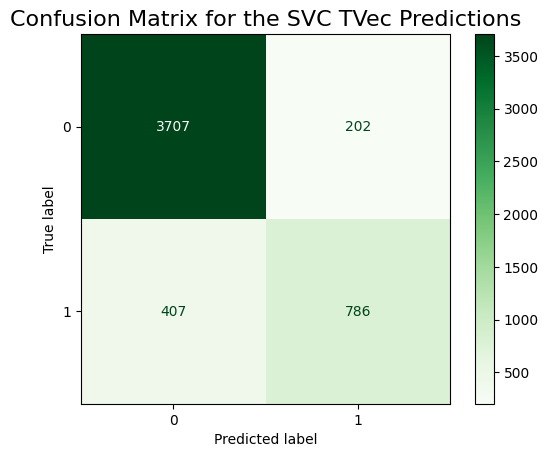

In [208]:
# Get predictions from optimal SVC model
preds = gs_chosen.predict(clean_test_total)
# Save confusion matrix values
tn17, fp17, fn17, tp17 = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_chosen, clean_test_total, y_test, cmap='Greens');
plt.title('Confusion Matrix for the SVC TVec Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [209]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp17/(tp17+fn17),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn17/(tn17+fp17),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp17+tn17)/(tp17+fp17+tn17+fn17),3)}")
# Calculate Precision
print(f"Precision | {round(tp17/(tp17+fp17),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp17+fn17)/(tp17+fp17+tn17+fn17),3)}")

Sensitivity | 0.659
Specificity | 0.948
Accuracy | 0.881
Precision | 0.796
Miscalculation Rate | 0.119


In [210]:
print(f"F1 Score | {round(f1_score(y_test, preds),3)}")

F1 Score | 0.721


### Do not GridSearch For Pickling for Streamlit App

In [211]:
tvec_chosen = TfidfVectorizer(max_features=6000, ngram_range = (1, 2), min_df=0.0001, max_df=0.6)


In [212]:
X_train_tvec = tvec_chosen.fit_transform(clean_train_total)
X_test_tvec = tvec_chosen.transform(clean_test_total)

In [213]:
svc_chosen = SVC(C = 10)

In [214]:
svc_chosen.fit(X_train_tvec, y_train)


SVC(C=10)

In [215]:
print(f"Train Accuracy Score TVec SVC | {round(svc_chosen.score(X_train_tvec, y_train),5)}")
print(f"Test Accuracy Score TVec SVC | {round(svc_chosen.score(X_test_tvec, y_test),5)}")

Train Accuracy Score TVec SVC | 1.0
Test Accuracy Score TVec SVC | 0.88064


TN: 3707
FP: 202
FN: 407
TP: 786


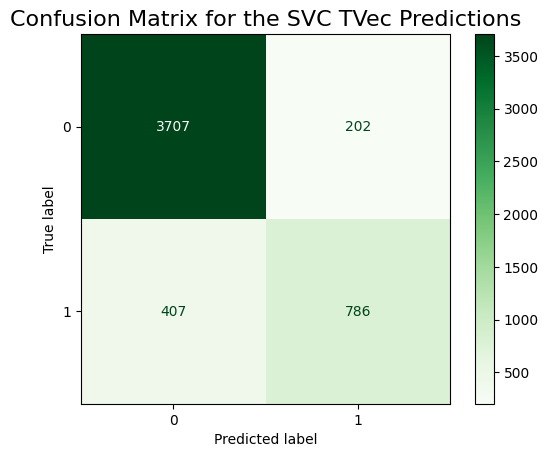

In [216]:
# Get predictions from optimal SVC model
preds = svc_chosen.predict(X_test_tvec)
# Save confusion matrix values
tn17, fp17, fn17, tp17 = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(svc_chosen, X_test_tvec, y_test, cmap='Greens');
plt.title('Confusion Matrix for the SVC TVec Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [217]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp17/(tp17+fn17),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn17/(tn17+fp17),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp17+tn17)/(tp17+fp17+tn17+fn17),3)}")
# Calculate Precision
print(f"Precision | {round(tp17/(tp17+fp17),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp17+fn17)/(tp17+fp17+tn17+fn17),3)}")

Sensitivity | 0.659
Specificity | 0.948
Accuracy | 0.881
Precision | 0.796
Miscalculation Rate | 0.119


In [218]:
print(f"F1 Score | {round(f1_score(y_test, preds),3)}")

F1 Score | 0.721


#### We confirm this works and now pickle the non-gridsearch model for Streamlit

In [219]:
# Save the model using pickle
model_filename = 'binary_classification_TVEC_nongrid.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(tvec_chosen, model_file)

In [220]:
# Save the model using pickle
model_filename = 'binary_classification_SVC_nongrid.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(svc_chosen, model_file)

### Move to directory with streamlit script

In [221]:
# print(f"Train Accuracy Score CVec SVC | {round(gs17.score(clean_train_total, y_train),5)}")
# print(f"Test Accuracy Score CVec SVC | {round(gs17.score(clean_test_total, y_test),5)}")

In [222]:
# print(f"Train Accuracy Score TVec SVC | {round(gs18.score(clean_train_total, y_train),5)}")
# print(f"Test Accuracy Score TVec SVC | {round(gs18.score(clean_test_total, y_test),5)}")

In [224]:
# # Get predictions from optimal KNN model
# preds = gs17.predict(clean_test_total)
# # Save confusion matrix values
# tn17, fp17, fn17, tp17 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs17, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Linear SVC CVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [225]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp17/(tp17+fn17),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn17/(tn17+fp17),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp17+tn17)/(tp17+fp17+tn17+fn17),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp17/(tp17+fp17),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp17+fn17)/(tp17+fp17+tn17+fn17),3)}")

In [226]:
# # Get predictions from optimal KNN model
# preds = gs18.predict(clean_test_total)
# # Save confusion matrix values
# tn18, fp18, fn18, tp18 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs18, clean_test_total, y_test, cmap='Reds');
# plt.title('Confusion Matrix for the Linear SVC TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [227]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp18/(tp18+fn18),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn18/(tn18+fp18),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp18+tn18)/(tp18+fp18+tn18+fn18),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp18/(tp18+fp18),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp18+fn18)/(tp18+fp18+tn18+fn18),3)}")

In [228]:
# print(f"F1 Score | {round(f1_score(y_test, preds),3)}")

#### Optimizing the best performing bagging, forest, and ADA
##### We do not run bagging and forest gridsearch as they are quite computationally expensive. Run ADA Only

In [229]:
# pipe_bgc = Pipeline([
#     ('cvec', CountVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('bg',BaggingClassifier())
# ])

# pipe_bgt = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     # ('ss', StandardScaler(with_mean=False)),
#     ('bg',BaggingClassifier())
# ])

# pipe_params_bgc = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#                'cvec__ngram_range': [(1,1), (1,2)],
#                 'cvec__min_df': [0.00005, 0.0001],
#                 'cvec__max_df': [0.6,0.65,0.7],
#                 'bg__n_estimators': [10, 15, 25],
#                 'bg__max_samples': [0.5, 0.7, 1.0],
#                 'bg__max_features': [0.5, 0.7, 1.0],
#                 'bg__verbose': [1]
                   
#               }

# pipe_params_bgt = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
#                'tvec__ngram_range' : [(1, 1), (1, 2)],
#                 'tvec__min_df': [0.00005, 0.0001],
#                 'tvec__max_df': [0.6,0.65,0.7],
#                 'bg__n_estimators': [10, 15, 25],
#                 'bg__max_samples': [0.5, 0.7, 1.0],
#                 'bg__max_features': [0.5, 0.7, 1.0],
#                 'bg__verbose': [1]
#               }

# # Instantiate GridSearchCV.

# gs_bgc = GridSearchCV(pipe_bgc, # what object are we optimizing?
#                   param_grid=pipe_params_bgc, # what parameters values are we searching?
#                   cv=3,
#                   n_jobs=-1) # 5-fold cross-validation.

# gs_bgt = GridSearchCV(pipe_bgt, # what object are we optimizing?
#                   param_grid=pipe_params_bgt, # what parameters values are we searching?
#                   cv=3, 
#                   n_jobs=-1) # 5-fold cross-validation.

# # Start the timer
# start_time = time.time()

# gs_bgc.fit(clean_train_total, y_train)

# # Stop the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the computation time
# print(f"Computation Time Cvec: {elapsed_time:.4f} seconds")

# # Start the timer
# start_time = time.time()

# gs_bgt.fit(clean_train_total, y_train)

# # Stop the timer
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the computation time
# print(f"Computation Time Tvec: {elapsed_time:.4f} seconds")


In [230]:

pipe_adac = Pipeline([
    ('cvec', CountVectorizer()),
    # ('ss', StandardScaler(with_mean=False)),
    ('ada', AdaBoostClassifier())
])

pipe_adat = Pipeline([
    ('tvec', TfidfVectorizer()),
    # ('ss', StandardScaler(with_mean=False)),
    ('ada', AdaBoostClassifier())
])

pipe_params_adac = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
               'cvec__ngram_range': [(1,1), (1,2)],
                'cvec__min_df': [0.00005, 0.0001],
                'cvec__max_df': [0.6,0.65,0.7],
                'ada__n_estimators': [50, 100, 200],
                'ada__learning_rate': [0.01, 0.1, 1.0]
              }

pipe_params_adat = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
               'tvec__ngram_range' : [(1, 1), (1, 2)],
                'tvec__min_df': [0.00005, 0.0001],
                'tvec__max_df': [0.6,0.65,0.7],
                'ada__n_estimators': [50, 100, 200],
                'ada__learning_rate': [0.01, 0.1, 1.0]
              }

# Instantiate GridSearchCV.

gs_adac = GridSearchCV(pipe_adac, # what object are we optimizing?
                  param_grid=pipe_params_adac, # what parameters values are we searching?
                  cv=5,
                  n_jobs=-1) # 5-fold cross-validation.

gs_adat = GridSearchCV(pipe_adat, # what object are we optimizing?
                  param_grid=pipe_params_adat, # what parameters values are we searching?
                  cv=5, 
                  n_jobs=-1) # 5-fold cross-validation.



# Start the timer
start_time = time.time()

gs_adac.fit(clean_train_total, y_train)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the computation time
print(f"Computation Time Cvec: {elapsed_time:.4f} seconds")


# Start the timer
start_time = time.time()

gs_adat.fit(clean_train_total, y_train)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the computation time
print(f"Computation Time Tvec: {elapsed_time:.4f} seconds")

Computation Time Cvec: 2749.1719 seconds
Computation Time Tvec: 4902.1197 seconds


## Metrics Section

### Bagging Classifier

In [248]:
# gs_bgc.best_params_

In [249]:
# gs_bgt.best_params_

In [250]:
# print(f"Train Accuracy Score CVec Bagging Tree | {round(gs_bgc.score(clean_train_total, y_train),5)}")
# print(f"Test Accuracy Score CVec Bagging Tree | {round(gs_bgc.score(clean_test_total, y_test),5)}")

In [251]:
# print(f"Train Accuracy Score TVec Bagging Tree | {round(gs_bgt.score(clean_train_total, y_train),5)}")
# print(f"Test Accuracy Score TVec Bagging Tree | {round(gs_bgt.score(clean_test_total, y_test),5)}")

In [252]:
# # Get predictions from optimal KNN model
# preds = gs_bgc.predict(clean_test_total)
# # Save confusion matrix values
# tn18, fp18, fn18, tp18 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs_bgc, clean_test_total, y_test, cmap='Purples');
# plt.title('Confusion Matrix for the Bagging Classifier CVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [253]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp18/(tp18+fn18),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn18/(tn18+fp18),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp18+tn18)/(tp18+fp18+tn18+fn18),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp18/(tp18+fp18),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp18+fn18)/(tp18+fp18+tn18+fn18),3)}")

In [254]:
# # Get predictions from optimal KNN model
# preds = gs_bgt.predict(clean_test_total)
# # Save confusion matrix values
# tn19, fp19, fn19, tp19 = confusion_matrix(y_test, preds).ravel()

# # Generate values of confusion matrix for reference
# def find_cm(y_test, preds):
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
#     return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# # View confusion matrix
# ConfusionMatrixDisplay.from_estimator(gs_bgt, clean_test_total, y_test, cmap='Purples');
# plt.title('Confusion Matrix for the Bagging Classifier TVec Predictions',fontsize=16, loc='center');

# print(find_cm(y_test, preds))

In [255]:
# # Calculate Sensitivity
# print(f"Sensitivity | {round(tp19/(tp19+fn19),3)}")
# # Calculate the Specificity
# print(f"Specificity | {round(tn19/(tn19+fp19),3)}")
# # Calculate Accuracy
# print(f"Accuracy | {round((tp19+tn19)/(tp19+fp19+tn19+fn19),3)}")
# # Calculate Precision
# print(f"Precision | {round(tp19/(tp19+fp19),3)}")
# # Calculate Miscalculation Rate
# print(f"Miscalculation Rate | {round((fp19+fn19)/(tp19+fp19+tn19+fn19),3)}")

In [256]:
gs_adac.best_params_

{'ada__learning_rate': 1.0,
 'ada__n_estimators': 200,
 'cvec__max_df': 0.6,
 'cvec__max_features': 8000,
 'cvec__min_df': 5e-05,
 'cvec__ngram_range': (1, 1)}

In [257]:
gs_adat.best_params_

{'ada__learning_rate': 1.0,
 'ada__n_estimators': 200,
 'tvec__max_df': 0.6,
 'tvec__max_features': 9000,
 'tvec__min_df': 5e-05,
 'tvec__ngram_range': (1, 1)}

In [258]:
print(f"Train Accuracy Score CVec ADA Boost | {round(gs_adac.score(clean_train_total, y_train),5)}")
print(f"Test Accuracy Score CVec ADA Boost | {round(gs_adac.score(clean_test_total, y_test),5)}")

Train Accuracy Score CVec ADA Boost | 0.85305
Test Accuracy Score CVec ADA Boost | 0.84379


In [259]:
print(f"Train Accuracy Score TVec ADA Boost | {round(gs_adat.score(clean_train_total, y_train),5)}")
print(f"Test Accuracy Score TVec ADA Boost | {round(gs_adat.score(clean_test_total, y_test),5)}")

Train Accuracy Score TVec ADA Boost | 0.87304
Test Accuracy Score TVec ADA Boost | 0.86535


TN: 3529
FP: 380
FN: 417
TP: 776


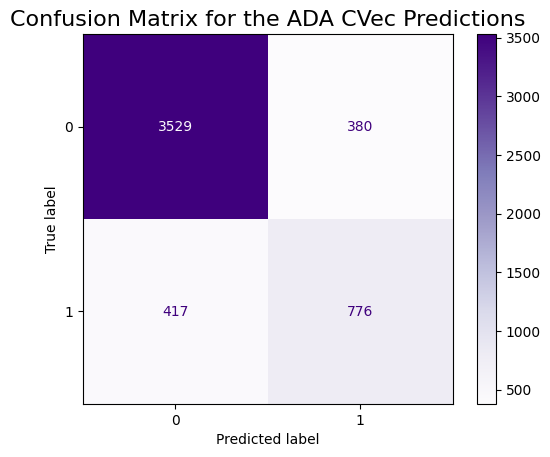

In [260]:
# Get predictions from optimal KNN model
preds = gs_adac.predict(clean_test_total)
# Save confusion matrix values
tn_adac, fp_adac, fn_adac, tp_adac = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_adac, clean_test_total, y_test, cmap='Purples');
plt.title('Confusion Matrix for the ADA CVec Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [261]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp_adac/(tp_adac+fn_adac),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn_adac/(tn_adac+fp_adac),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp_adac+tn_adac)/(tp_adac+fp_adac+tn_adac+fn_adac),3)}")
# Calculate Precision
print(f"Precision | {round(tp_adac/(tp_adac+fp_adac),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp_adac+fn_adac)/(tp_adac+fp_adac+tn_adac+fn_adac),3)}")

Sensitivity | 0.65
Specificity | 0.903
Accuracy | 0.844
Precision | 0.671
Miscalculation Rate | 0.156


TN: 3682
FP: 227
FN: 460
TP: 733


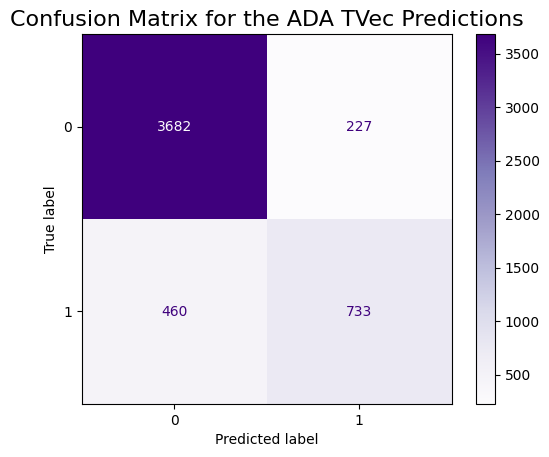

In [262]:
# Get predictions from optimal KNN model
preds = gs_adat.predict(clean_test_total)
# Save confusion matrix values
tn_adat, fp_adat, fn_adat, tp_adat = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_adat, clean_test_total, y_test, cmap='Purples');
plt.title('Confusion Matrix for the ADA TVec Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

In [263]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp_adat/(tp_adat+fn_adat),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn_adat/(tn_adat+fp_adat),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp_adat+tn_adat)/(tp_adat+fp_adat+tn_adat+fn_adat),3)}")
# Calculate Precision
print(f"Precision | {round(tp_adat/(tp_adat+fp_adat),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp_adat+fn_adat)/(tp_adat+fp_adat+tn_adat+fn_adat),3)}")

Sensitivity | 0.614
Specificity | 0.942
Accuracy | 0.865
Precision | 0.764
Miscalculation Rate | 0.135


In [264]:
f1_score(y_test, preds)

0.6809103576405016

### Summary

Support Vector Machine Classifier (SVC) TfidfVectorier (TVec) performed very well in specificity and accuracy and F1 score was also acceptable: 

Sensitivity | 0.659

Specificity | 0.948

Accuracy | 0.881

Precision | 0.796

Miscalculation Rate | 0.119

F1 Score | 0.721.

ADA Boost was the closest fit model in terms of accuracy scores with 

Train Accuracy Score CVec ADA Boost | 0.85305

Test Accuracy Score CVec ADA Boost | 0.84379

and 

Train Accuracy Score TVec ADA Boost | 0.87304

Test Accuracy Score TVec ADA Boost | 0.86535.

### We export the SVC model and use this for binary classification in our Streamlit application to differentiate whether or not an abstract/headline coupling originated from an `Opinion` section or a `non-Opinion` section. 